# Рынок заведений общественного питания Москвы

## Общее описание проекта
По открытым данным о заведениях общественного питания в Москве требуется провести исследование рынка.

## Описание располагаемых данных

Данные о заведениях общественного питания Москвы содержатся в файле `rest_data`. Каждая запись характеризуется следующим набором признаков:

|Признак|Описание|
|------:|:-------|
|`id` | идентификатор объекта|
|`object_name` | название объекта общественного питания|
|`chain` | сетевой ресторан|
|`object_type` | тип объекта общественного питания|
|`address` | адрес|
|`number` |  количество посадочных мест|



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, normaltest


In [2]:
df = pd.read_csv('project3.csv')
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


С ипользованием метода info() получить общие сведения верности определенных типов данных и полноте заполнения строй датафрейма
Результа: в датафрейме 15366 записей. Пропуски отсутствуют. Типы данных определенны в соответствии с физическим смыслом параметров 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Проверим наличие дубликатов в исходном датафрейме
Для избегания случая, когда одна и та же запись может иметь разные id, проверим на наличие дубликатов датафрейм без колонки id
Метод dublicated нашел 82 дубликата ( Примечание: поиск на всем датафрейме не обнаружил дубликатов)


In [4]:
df[df.drop('id', axis = 1).duplicated()].id.count()

82

Удалим дубликаты. Для этого выделим индексы дубликатов и удалить записи с этими индексами. после удаления дубликатов в датафрейме оказалось 15284 записей

In [5]:
df.drop(index = df[df.drop('id', axis = 1).duplicated()].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15284 non-null  int64 
 1   object_name  15284 non-null  object
 2   chain        15284 non-null  object
 3   object_type  15284 non-null  object
 4   address      15284 non-null  object
 5   number       15284 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.8+ KB


Оценим диапазоны значений для интервальных параметров. В данном датафрейсе существенным является только параметр number. Для этого применим метод describe. Минимальной значение - 0. Максимальное значение 1700. Эти значения нельзя считать аномальными, т.к. в Москве существует заведение с объявленным количеством посадочных мечт 1700 (Arena by Soho Family на Кутузовском проспекте). А количество 0 относится к заведениям быстрого питания с высокими столиками без стульев и фактически без посадочных мест. Там все места стоячие.

In [6]:
df['number'].describe()

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Проверим типы объектов общественного питания на отсутствие 'нереальных' типов. В датафрейме присутствут следующие типы объектов общественного питания: кафе, столовая, закусочная,
предприятие быстрого обслуживания, ресторан, кафетерий,буфет, бар, магазин (отдел кулинарии). Все типы вполне реальны. Возможно существуют еще и другие типы объектов общественного питания. Но в данном датасете приведены именно эти типы и они объективно реальные 

In [7]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Проверим однозначность деления всех объектов общественного питания на принадлежность с сетевым. Для этого проверим значения параметра chain.
Параметр chain принимает только два значения: да, нет. Следовательно все объекты общественного питания обнозначно разделенны на две группы по принадлежности к сетевым

In [8]:
df['chain'].unique()

array(['нет', 'да'], dtype=object)

Для дальнейшем обработки данных нам будет необходимо изучать данные в привязке к адресу нахождения объекта общественного питания. Данные об адресе могут содержать неточности ( из-за человеческого фактора). Адрес является многосоставным и могут быть ошибки при его наборе оператором. Кроме того, в Москве много присоединенных территорий ( поселения, поселки, город Зеленоград, Новая Москва и и т.д.), которые, при необходимости, мы рассмотрим отдельно. Т.е. нам необходимо выбрать только адреса, которые имеют точную привязку к городу Москве, без нахождения на присоединенных административно территориях.

Если взглянуть на запись адреса в исходном датафрейме, то в общем виде адрес представлен в формате: город Москва, улица ( проспект,...), адрес дома на улице. Преобразуем все адреса именно к такому виду, убрав все адреса присоединенных территорий.

Сначала определим имеются ли адреса без указания города Москвы. Таких записей оказалась 71. Изменим эти записи, добавив в адрес строку 'город Москва'

In [9]:
ss = df.address.apply(lambda x: x.split(',')[0])
indx = ss[ss != 'город Москва'].index
df.loc[indx, 'address'] = 'город Москва, ' + df.loc[indx, 'address']
df.shape

(15284, 6)

Далее разделим адрес на составные части: город Москва, улицы и т.п., адрес на улице. При этом уберем из датафрейма адреса присоединенных территорий. После первичного разделения на 3 части ( город, улица..., адрес на улице) все данные об адресах на присоединенных территориях находятся в столбце 'street'. 

### Выделение из адреса Города, Улицы и Адреса на улице

In [10]:
df['address'] = df['address'].apply(lambda x:x.split(','))
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"[город Москва, улица Егора Абакумова, дом 9]",48
1,77874,Родник,нет,кафе,"[город Москва, улица Талалихина, дом 2/1, к...",35
2,24309,Кафе «Академия»,нет,кафе,"[город Москва, Абельмановская улица, дом 6]",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"[город Москва, Абрамцевская улица, дом 1]",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"[город Москва, Абрамцевская улица, дом 9, к...",50


In [11]:
df['city'] = df['address'].apply(lambda x: x[0].split()[1])
df['street'] = df['address'].apply(lambda x: x[1])
df['house'] = df['address'].apply(lambda x: x[2:])

In [65]:
df.head(1)

,id,object_name,chain,object_type,address,number,city,street,house
0,151635,СМЕТАНА,нет,кафе,"[город Москва, улица Егора Абакумова, дом 9]",48,Москва,улица Егора Абакумова,[ дом 9]


Выберем из столбца street все адреса присоединенных территорий.
Определять принадлежность адреса к присоединенной территории будем по следующему алгоритму: Все улицы, проспекты и т.п. типы "улиц" в столбце street начинаются с буквы в нижнем регистре, а их названия начинаются с букв в верхнем регистре ( как имена нарицательные). Выберем список уникальный значений этих 'улиц'. Среди так называемых "улиц" присутствуют слова: город ( Зеленоград, Троицк, Московский), деревня, поселение, поселок. Судя по формулировке это отдельная административная единица, которая была присоединена к Москве. 
Уберем из датафрейма все записи с адресами в этих "городах, деревнях, поселениях, поселках.
После удаления адресов присоединенных территорий в датафрейме осталось 14461 записей. Таком образом после удаления дубликатов и адресов присоединенных территорий количество записей уменьшилось на 905 единиц ( около 6% ).

In [13]:
aa = df.street.apply(lambda x: x.split(' '))
set([x  for row in aa.values.tolist() for x in row if x.islower()])

{'1-й',
 '1-я',
 '10-летия',
 '104-й',
 '11-я',
 '113а',
 '12-й',
 '12-я',
 '13-я',
 '14-я',
 '15-я',
 '16-я',
 '17-й',
 '19-й',
 '2-й',
 '2-я',
 '26-й',
 '26-ти',
 '28-й',
 '3-й',
 '3-я',
 '30-й',
 '31-й',
 '33-й',
 '34-й',
 '38-й',
 '4-й',
 '4-я',
 '42-й',
 '5-й',
 '5-я',
 '56-й',
 '6-й',
 '6-я',
 '60-летия',
 '65-й',
 '67-й',
 '7-й',
 '7-я',
 '73-й',
 '74-й',
 '78-й',
 '8-й',
 '8-я',
 '80-й',
 '800-летия',
 '82-й',
 '87-й',
 '9-я',
 'аллея',
 'бульвар',
 'город',
 'деревня',
 'и',
 'квартал',
 'километр',
 'лет',
 'линия',
 'микрорайон',
 'набережная',
 'переулок',
 'площадь',
 'поселение',
 'посёлок',
 'проезд',
 'проектируемый',
 'просек',
 'проспект',
 'территория',
 'тупик',
 'улица',
 'шоссе'}

In [14]:
out_moscow = ['город','поселение','деревня','село']

In [15]:
out_moscow = ['город','поселение','деревня','село']
def value(s, name):
    return name in s.split()

for name in out_moscow:
    ss = df.street
    indx = ss[ss.apply(lambda x: value(x, name))].index
    df.drop(index = indx, inplace=True)
    print(f"Удалили из датафрейма адреса с признаком - {name}")


Удалили из датафрейма адреса с признаком - город
Удалили из датафрейма адреса с признаком - поселение
Удалили из датафрейма адреса с признаком - деревня
Удалили из датафрейма адреса с признаком - село


### Распределение объектов общественного питания по типам

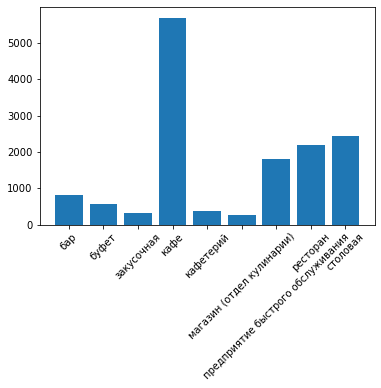

In [66]:
s = df.groupby('object_type').aggregate({'id':'count'}).reset_index()
plt.bar(s['object_type'], s['id'])
plt.xticks(rotation = 45)
plt.show()


наибольшее количество объектов общественного питания имеют категорию Кафе

### Соотношение между количеством сетевых объектов и не сетевых

In [17]:
s = df.groupby('chain').aggregate({'id':'count'}).reset_index()
s = s.rename(columns = {'chain':'Сетевой объект', 'id':'Количество'})

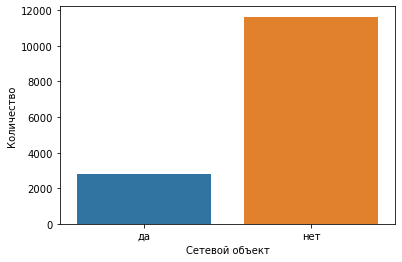

In [18]:
sns.barplot(data = s, x = s['Сетевой объект'], y = s['Количество'])
plt.show()

In [19]:

print(f"Сетевые объекты общественного питания составляют около {s[s['Сетевой объект'] == 'да']['Количество'].sum()/s['Количество'].sum()*100:.2f} процентов")

Сетевые объекты общественного питания составляют около 19.51 процентов


### Определение какому типу объекта общественного питания характерно сетевое распространение

In [68]:
s = df.groupby(['object_type', 'chain']).aggregate({'id':'count'})

In [69]:
s.reset_index(inplace = True)
s = s.rename(columns = {'object_type':'Тип объекта общественного питания', 'id':'Количество'})

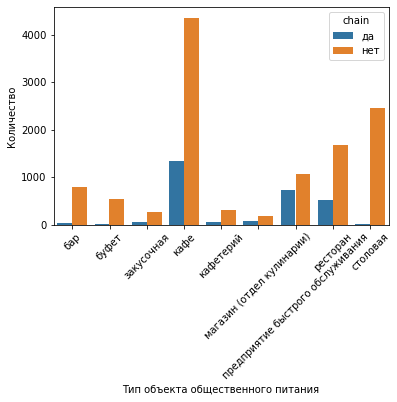

In [70]:
sns.barplot(data=s, x = 'Тип объекта общественного питания', y = 'Количество', hue = 'chain')
plt.xticks(rotation = 45)
plt.show()

In [23]:
type_chain = pd.pivot_table(s, columns='chain', values ='Количество', index ='Тип объекта общественного питания')

In [24]:
type_chain['Процент'] =round(type_chain['да']*100/(type_chain['нет']+type_chain['да']),2)

In [25]:
type_chain

chain,да,нет,Процент
Тип объекта общественного питания,,,
бар,36,790,4.36
буфет,11,547,1.97
закусочная,54,266,16.88
кафе,1340,4362,23.50
кафетерий,51,314,13.97
магазин (отдел кулинарии),77,174,30.68
предприятие быстрого обслуживания,734,1065,40.80
ресторан,516,1673,23.57
столовая,3,2448,0.12


Наибольший процент объектов общественного питания, принадлежащих  сетевым, среди предприятий быстрого обслуживания. В абсолютном выражении наибольшее количество объектов, явлющихся сетевыми, находятся среди кафе. Практически отсутствуют сетевые объекты общественного питания среди столовых и буфетов.

### Много малых - мало больших

Для введения однозначности понятия "небольшое количество посадочных мест" будет считать граничным значениям величину медианы значений количества посадочных мест

In [26]:
s_chain = df[df['chain'] == 'да'].groupby('number').aggregate({'id':'count'})
s_chain.reset_index(inplace=True)
s_chain.rename(columns = {'id':'Количество','number':'Посадочные места'}, inplace = True)
s_chain.head()

,Посадочные места,Количество
0,0,234
1,1,15
2,2,29
3,3,16
4,4,42


In [27]:
number_median = s_chain['Посадочные места'].median()
print(f"Медианное значение количества посадочных мест - {number_median}")

Медианное значение количества посадочных мест - 99.0


In [28]:
print(f"Объектов с числом посадочных мест больше медианного значения "
      f"{s_chain[s_chain['Посадочные места'] > number_median]['Количество'].sum()}")

Объектов с числом посадочных мест больше медианного значения 382


In [29]:
print(f"Объектов с числом посадочных мест меньше медианного значения "
      f"{s_chain[s_chain['Посадочные места'] < number_median]['Количество'].sum()}")

Объектов с числом посадочных мест меньше медианного значения 2433


Значение 99 может показаться большим для понятия "небольшое количество посадочных мест". Сдвинем границы: небольшое количество - меньше 0.5 медианы, большое количество 1.5 медианы

In [30]:
print(f"Объектов с числом посадочных мест больше чем 3/2 медианного значения "
      f"{s_chain[s_chain['Посадочные места'] > 1.5*number_median]['Количество'].sum()}")

Объектов с числом посадочных мест больше чем 3/2 медианного значения 200


In [31]:
print(f"Объектов с числом посадочных мест меньше 1/2 медианного значения "
      f"{s_chain[s_chain['Посадочные места'] < 0.5*number_median]['Количество'].sum()}")

Объектов с числом посадочных мест меньше 1/2 медианного значения 1702


Строим график распределения числа объектов по количеству посадочных мест


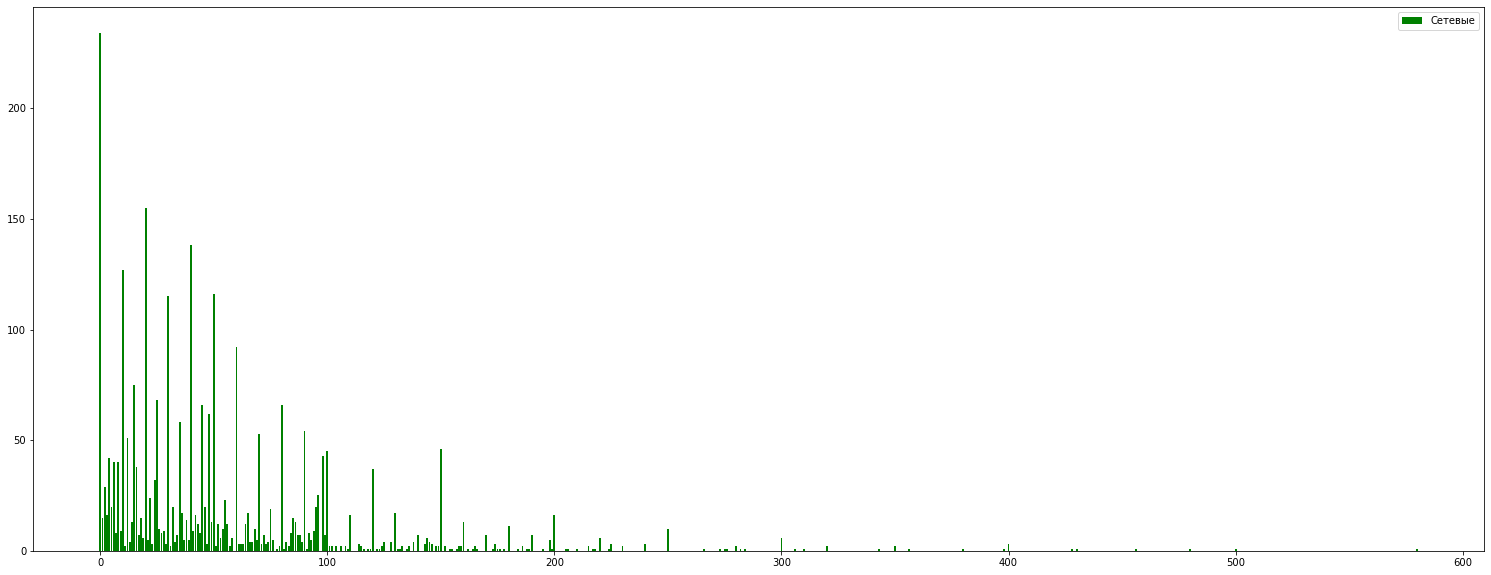

In [32]:
plt.figure(figsize=(26,10))
plt.bar(s_chain['Посадочные места'], s_chain['Количество'], color = 'green', label = 'Сетевые')
plt.legend()
plt.show()

График подтверждает вывод о том, что для сетей количество заведений с небольшим числом посадочных мест в каждом больше чем количество заведений с большим количеством посадочных мест
Это объяснимо, т.к. масштабируемость сетевых заведений характерно для объектов массового потокового посещения. А это заведения с небольшим числом посадочных мест

### Среднее количество посадочных мест

In [33]:
s = df.groupby('object_type').aggregate({'number':'mean'})
s.reset_index(inplace=True)
s.rename(columns = {'object_type':'Тип объекта питания', 'number':\
                    'Среднее количество посадочных мест'})

,Тип объекта питания,Среднее количество посадочных мест
0,бар,43.891041
1,буфет,52.172043
2,закусочная,8.121875
3,кафе,40.720624
4,кафетерий,9.328767
5,магазин (отдел кулинарии),6.007968
6,предприятие быстрого обслуживания,20.918844
7,ресторан,97.802193
8,столовая,130.404325


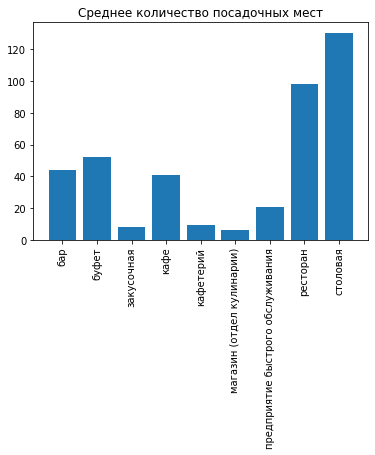

In [34]:
plt.bar(s['object_type'], s['number'])
plt.xticks(rotation = 90)
plt.title('Среднее количество посадочных мест')
plt.show()

Наибольшее среднее количество посадочных мест в заведения типа - столовая

### Улицы

street                          проспект Мира
Количество объектов питания               204
Name: 1382, dtype: object


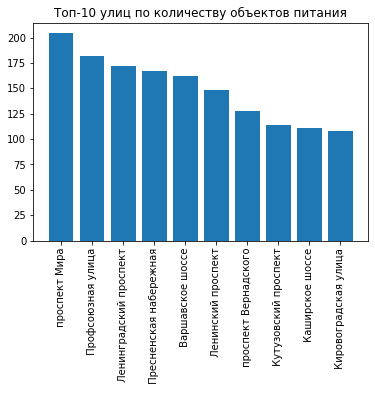

In [35]:
street = df.groupby('street').aggregate({'id':'count'})
street.reset_index(inplace = True)
street.rename(columns ={'id':'Количество объектов питания'}, inplace = True)
street.sort_values('Количество объектов питания', ascending=False, inplace = True)
print(street.iloc[0])
plt.bar(street.iloc[:10,:]['street'], street.iloc[:10,:]['Количество объектов питания'])
plt.xticks(rotation = 90)
plt.title("Топ-10 улиц по количеству объектов питания")
plt.show()

Наибольшее количество объектов общественного питания -204   находится на проспекте Мира

### Улицы с домашним питанием

In [36]:
s_one = street[street['Количество объектов питания'] == 1]
print(f"Количество улиц, на которых расположен всего один объект питания - "
      f"{s_one['Количество объектов питания'].count()}")

Количество улиц, на которых расположен всего один объект питания - 540


In [37]:
s_one_object = df.iloc[s_one.index,:].groupby('object_type').aggregate({'id':'count'})
max_amount = s_one_object.max().values[0]
print(f"Среди объектов питания, которые являются единственными на улице больше всего "
      f"{s_one_object[s_one_object['id'] == max_amount].index[0]} ({ max_amount} единиц)")

Среди объектов питания, которые являются единственными на улице больше всего кафе (272 единиц)


### Улицы с большим количеством объектов питания

In [38]:
street10 = street.iloc[:10,:]
print('10 улиц с наибольших количеством объектов питания:')
for name in street10['street'].values:
    print(f" - {name}")

10 улиц с наибольших количеством объектов питания:
 -  проспект Мира
 -  Профсоюзная улица
 -  Ленинградский проспект
 -  Пресненская набережная
 -  Варшавское шоссе
 -  Ленинский проспект
 -  проспект Вернадского
 -  Кутузовский проспект
 -  Каширское шоссе
 -  Кировоградская улица


#### Для каждой улицы определим количество посадочных мест с разбивкой по объектам питания

In [39]:
street_number = df.groupby(['street', 'object_type']).aggregate({'number':'sum'})
street_number.reset_index(inplace = True)
street_number

,street,object_type,number
0,1-й Автозаводский проезд,кафе,20
1,1-й Автозаводский проезд,кафетерий,4
2,1-й Автозаводский проезд,ресторан,90
3,1-й Амбулаторный проезд,столовая,140
4,1-й Балтийский переулок,ресторан,60
...,...,...,...
4753,шоссе Энтузиастов,кафетерий,38
4754,шоссе Энтузиастов,магазин (отдел кулинарии),6
4755,шоссе Энтузиастов,предприятие быстрого обслуживания,127
4756,шоссе Энтузиастов,ресторан,786


#### Выбираем только данные для ТОП -10 улиц

In [40]:
street_number10 = street_number.loc[street_number['street'].isin(street10['street'].values)]

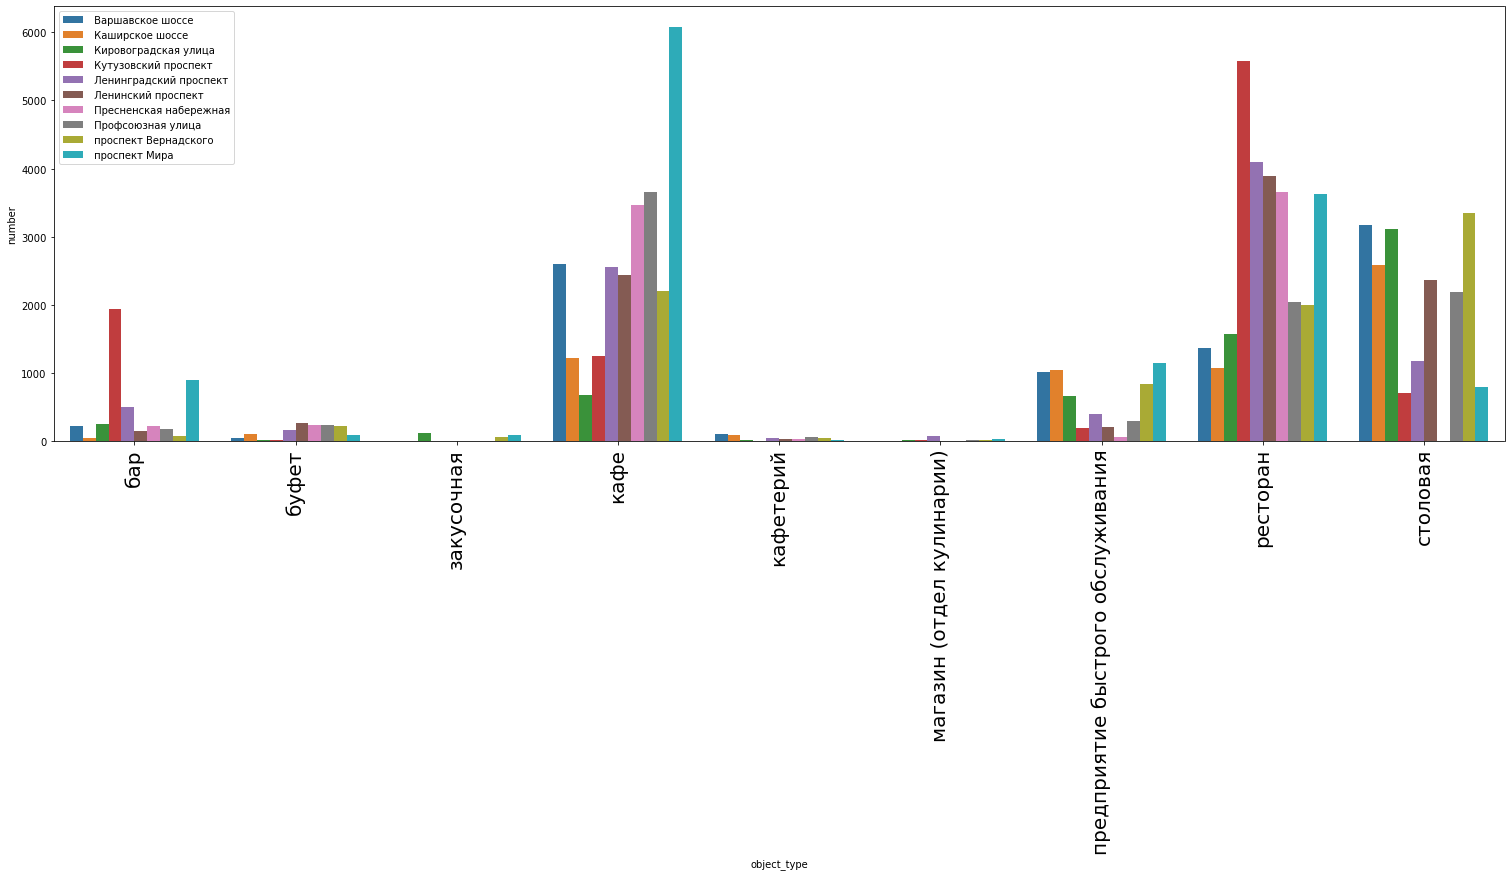

In [41]:
plt.figure(figsize=(26,8))
sns.barplot(data = street_number10, x = 'object_type', y = 'number', hue = 'street')
plt.legend()
plt.xticks(rotation = 90, fontsize = 20);

На графике видно что среди выбранных 10 улиц наибольшее количество объектов питания наблюдается среди кафе, ресторанов и столовых

### Гипотеза о равенстве количества посадочных мест в заведениях сетевого и не сетевого типа

Гипотеза H0: среднее количество посадочных мест для одного типа объекта питания не зависит от сетевого типа 

Гипотеза H1: среднее количество посадочных мест для одного типа объекта питания определется принадлежностью к сетевому типу 

Формируем наборы значений количества посадочных мест для объектов питания в двух группах (сетевые и несетевые)


In [42]:
chain_true = df[df['chain'] == 'да'][['object_type', 'number']]
chain_false = df[df['chain'] == 'нет'][['object_type', 'number']]

Для проверки гипотезы ограничим значения количества посадочных мест в интервале (0.01, 0.99) квантилей. Т.е. уберем предельно крайние значения

In [54]:
f_qwan = chain_false['number'].quantile(0.99)
t_qwan = chain_true['number'].quantile(0.99)
f_qwan, t_qwan

(280.0, 220.0)

In [56]:
indx = chain_false[chain_false['number'] > f_qwan].index
chain_false.drop(index=indx, inplace=True)

In [57]:
indx = chain_true[chain_true['number'] > t_qwan].index
chain_true.drop(index=indx, inplace=True)

In [59]:
chain_false['number'].min()

1

In [47]:
set( chain_false['object_type'].values)

{'бар',
 'буфет',
 'закусочная',
 'кафе',
 'кафетерий',
 'магазин (отдел кулинарии)',
 'предприятие быстрого обслуживания',
 'ресторан',
 'столовая'}

Анализ графиков распределения количества посадочных мест для отдельных типов объектов питания показал что распеделение количества посадочных мест не соответствует нормальному распределению. Поэтому для проверки гипотезы о независимости  числа посадочных от принадлежности к сетевым объекта будет применяться U - критерий Манна-Уитни. Уровень значимости p-value примем равным 0.05

Проверять гипотезу будет отдельно для каждого типа обьъекта питания

In [60]:
def test_student(chain_true, chain_false):
        return ttest_ind(chain_true, chain_false,equal_var=False)
    
def test_mu(chain_true, chain_false):
    return mannwhitneyu(chain_true, chain_false)

def norm(numbers):
    alpha = 0.05
    print(numbers.min())
    stat1, p1 = normaltest(numbers) # Критерий согласия Пирсона
    print(f"Statistics={stat1:.3f}, p-value={p1:.3f}")
    if p1 > alpha:
        return True
    else:
        return False
    
number_diff = []
number_equal = {}
for name in set(chain_false['object_type'].values):
    chain_2 =chain_false[chain_false['object_type'] == name].loc[:,'number'].values
    if name in set(chain_true['object_type'].values):
        chain_1 =  chain_true[chain_true['object_type'] == name].loc[:,'number'].values
#        if norm(chain_1) and norm(chain_2):
        u, pvalue = test_mu(chain_1, chain_2)
        if pvalue >= 0.05:
            number_equal[name] = u,pvalue
                #print(f"Для объектов питания {name} возможно одинаковое распределение посадочных мест ")
                #print('u-статистика %0.3f p-value %0.3f' % (u, pvalue))
        else:
            number_diff.append(name)
#        else:
#            t, pvalue = test_mu(chain_1, chain_2)
#            if pvalue >= 0.05:
#                number_equal[name] = t,pvalue
#                #print(f"Для объектов питания {name} возможно одинаковое распределение посадочных мест ")
#                #print('t-статистика %0.3f p-value %0.3f' % (t, pvalue))
#            else:
#                number_diff.append(name)
print(f"\nТипы объектов питания,для которых не отвергается гипотеза "
      f"о независимости среднего количества\nпосадочных мест от принадлежности к сетевому типу:")
for key, values in number_equal.items():
    print(f" - {key} : ( u-статистика { values[0]:.3f} p-value {values[1]:0.3f})")

                #print(')
            
print(f"\nТипы объектов питания,для которых не подтверждается гипотеза "
      f"о независимости среднего количества\nпосадочных мест от принадлежности к сетевому типу:")
for name in number_diff:
    print(f" - {name}")
                
        
    

        


Типы объектов питания,для которых не отвергается гипотеза о независимости среднего количества
посадочных мест от принадлежности к сетевому типу:
 - кафетерий : ( u-статистика 4927.500 p-value 0.058)
 - буфет : ( u-статистика 770.500 p-value 0.902)
 - бар : ( u-статистика 15640.500 p-value 0.083)
 - столовая : ( u-статистика 3538.000 p-value 0.940)

Типы объектов питания,для которых не подтверждается гипотеза о независимости среднего количества
посадочных мест от принадлежности к сетевому типу:
 - ресторан
 - магазин (отдел кулинарии)
 - закусочная
 - предприятие быстрого обслуживания
 - кафе


Полученный результат может объясняться тем, что количество объектов среди сетевых и несетевых объектов питания типа бар, кафетерий, столовая, буфет очень сильно различаются( от 3/2448 (столовая) до 36/790 (бар) и скорее всего множества количеств посадочных мест могут просто сильно пересекаться.
Проверка пересечений этих множест показала:
- Для столовых соотвествующее множество посадочных мест сетевых объектов полностью входит в множество для несетевых объектов ( все 3 варианта количества посадочных мест входят в множество для несетевых объектов)
- Аналогично для буфетов
- Для баров. Из 35 вариантов для сетевых объектов 23 варианта входят в множество для несетевых объектов ( 762 варианта)
- Для кафетериев. Из 37 вариантов для сетевых объектов 17 вариантов входят в множество для несетевых объектов ( 223 варианта)

 

In [63]:
names = ['столовая', 'буфет', 'бар','кафетерий','ресторан','магазин (отдел кулинарии)'\
         ,'закусочная','предприятие быстрого обслуживания','кафе']
for name in names:
    stol_true = chain_true[chain_true['object_type'] ==name]['number'].values.tolist()
    stol_false = chain_false[chain_false['object_type'] ==name]['number'].values.tolist()
    true_false = set(stol_true).intersection(set(stol_false))
    print(f"размер выборки для объекта {name} сетевые/несетевые' - {len(stol_true)}/{len(stol_false)}")
    print(f"размер пересечения - {len(true_false)}: {round(len(true_false)/len((stol_true))*100,2)} % ")

размер выборки для объекта столовая сетевые/несетевые' - 3/2301
размер пересечения - 3: 100.0 % 
размер выборки для объекта буфет сетевые/несетевые' - 3/493
размер пересечения - 3: 100.0 % 
размер выборки для объекта бар сетевые/несетевые' - 35/762
размер пересечения - 23: 65.71 % 
размер выборки для объекта кафетерий сетевые/несетевые' - 37/223
размер пересечения - 17: 45.95 % 
размер выборки для объекта ресторан сетевые/несетевые' - 469/1587
размер пересечения - 83: 17.7 % 
размер выборки для объекта магазин (отдел кулинарии) сетевые/несетевые' - 45/80
размер пересечения - 17: 37.78 % 
размер выборки для объекта закусочная сетевые/несетевые' - 36/118
размер пересечения - 13: 36.11 % 
размер выборки для объекта предприятие быстрого обслуживания сетевые/несетевые' - 627/514
размер пересечения - 43: 6.86 % 
размер выборки для объекта кафе сетевые/несетевые' - 1281/4127
размер пересечения - 110: 8.59 % 
